In [3]:
import os
import re
import requests
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import simplejson as json
from datetime import datetime

# Stage 1: Maoyan

## Get website response and font data

In [4]:
browserOptions = Options()
#browserOptions.add_argument("--headless")

capa = DesiredCapabilities.CHROME
capa["pageLoadStrategy"] = "none"
capa["goog:loggingPrefs"] = {"performance": "ALL"}
driver = webdriver.Chrome(desired_capabilities=capa, chrome_options=browserOptions)
wait = WebDriverWait(driver, 20)

#create snapshot of the entire page to prevent it from constantly changing
driver.get("https://piaofang.maoyan.com/dashboard/movie")
test = None
while not test:
    try:
        test = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'moviename-td')))
    except:
        driver.refresh();

now = datetime.now().strftime("%d-%m-%Y_%H:%M:%S") # get exact datetime at the time of scrape
os.mkdir("logs/" + now)

driver.get_screenshot_as_file("logs/" + now + "/screenshot.png") # save screenshot to sanity check later

logs_raw = driver.get_log("performance")
logs = [json.loads(lr["message"])["message"] for lr in logs_raw]

def log_filter(log_):
    return (
        # is an actual response
        log_["method"] == "Network.responseReceived"
        # and json
        and "json" in log_["params"]["response"]["mimeType"]
    )

responses = []

for log in filter(log_filter, logs):
    request_id = log["params"]["requestId"]
    resp_url = log["params"]["response"]["url"]
    print(f"Caught {resp_url}")
    response = driver.execute_cdp_cmd("Network.getResponseBody", {"requestId": request_id})
    responses.append(response)

/Users/azicon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: use options instead of chrome_options
  import sys


Caught https://piaofang.maoyan.com/dashboard-ajax/movie?orderType=0&uuid=5c3c9152-2cf7-44e3-956b-bc1ee59fe653&timeStamp=1646464018879&User-Agent=TW96aWxsYS81LjAgKE1hY2ludG9zaDsgSW50ZWwgTWFjIE9TIFggMTBfMTVfNykgQXBwbGVXZWJLaXQvNTM3LjM2IChLSFRNTCwgbGlrZSBHZWNrbykgQ2hyb21lLzk3LjAuNDY5Mi45OSBTYWZhcmkvNTM3LjM2&index=234&channelId=40009&sVersion=2&signKey=f8457c953fce19de4e08d92aa17a6d05


In [5]:
# Get this instance's font file from backend server
body0 = json.loads(responses[0]['body'])
movieList = body0['movieList']['list']
date = body0['calendar']['today']
font_url = body0['fontStyle'].split('"')[-2]

# Get reference fonts from the file tree
from fontTools.ttLib import TTFont
headers = {
            "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/537.36 (KHTML, like Gecko) "
              "Chrome/66.0.3359.139 Safari/537.36 "
    }

woff_url = 'http:' + font_url
response_woff = requests.get(woff_url, headers=headers).content

print("Woff retrieval succuessful: " + str(len(response_woff) > 0))

with open('temp/fonts.woff', 'wb') as f:
    f.write(response_woff)

Woff retrieval succuessful: True


In [6]:
driver.close() # we don't need the driver anymore from this point forward

## Getting digits from the font data using pytesseract

In [7]:
from fontTools.ttLib import TTFont
from PIL import ImageFont, Image, ImageDraw, ImageOps
import pytesseract
import cv2
import numpy as np
import random

def uniToHex(uni):
    return "&#x" + uni[3:].lower()

def uni_2_png_stream(txt: str, font: str, img_size=512, font_size=0.7, invert=False):
    img = Image.new('1', (img_size, img_size), 255) 
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font, int(img_size * font_size))
    
    txt = chr(txt)
    x, y = draw.textsize(txt, font=font) 
    draw.text(((img_size - x) // 2, (img_size - y) // 2), txt, font=font, fill=0)
    if invert:
        img = img.convert('L')
        img = ImageOps.invert(img)
        img = img.convert('1')
    #img.save(txt + '.png')
    return img 

def predict_neural(unicode, fontFile):
    image = uni_2_png_stream(int(unicode[3:], 16), fontFile, img_size=28, font_size=0.5, invert=True)
    image.save(str(unicodeToInt[unicode]) + '_neuro.png')
    matrix_form = np.array(image)
    weighted_predictions = np.ndarray.flatten(neural_network.run(matrix_form))
    most_possible = np.argmax(weighted_predictions)
    return most_possible

def predict_tesseract(unicode, fontFile, fontSize=0.5):
    image = uni_2_png_stream(int(unicode[3:], 16), fontFile, img_size=1024, font_size=fontSize)
    image.save('logs/' + str(now) + '/' + str(unicode) + '.png')
    text = pytesseract.image_to_string(image, lang="eng", config="--psm 10 outputbase digits -c tessedit_char_whitelist=0123456789")
    return text

def predict_tesseract_definite(unicode, fontFile):
    result, size = '', 1
    while not result and size >= 0:
        result = predict_tesseract(x, filename, fontSize=size)
        size -= 0.01
    return result

In [8]:
# Map contours to numbers - the prediction phase may be very slow
filename = 'temp/fonts.woff'
f = TTFont(filename)
hexToInt = {}
for x in f.getGlyphNames()[1:-1]:
    predict = predict_tesseract_definite(x, filename)
    hexToInt[uniToHex(x)] = int(predict)

hexToInt

2 extra bytes in post.stringData array


{'&#xe058': 4,
 '&#xe514': 0,
 '&#xe6c1': 1,
 '&#xeab3': 8,
 '&#xeb55': 9,
 '&#xf0b5': 6,
 '&#xf201': 5,
 '&#xf231': 3,
 '&#xf2fe': 2,
 '&#xf560': 7}

## Parsing the data into pandas dataframe

In [9]:
import pandas as pd
df = pd.DataFrame.from_records(movieList)

In [10]:
unitLookup = {'百': 100, '千': 1000, '万': 10000, '亿': 1*10**8}

#converts the weird character to a float
def convertToFloat(string):
    spCharLst = string.split(';')
    result = ''
    for i in spCharLst:
        if len(i) > 7: #has a dot in front
            result += '.' + str(hexToInt[i[1:]])
        elif len(i) == 7: #in case of bad parsing
            result += str(hexToInt[i])
    return float(result)

#helper function for converting the entire block to a single int
def convertDictToInt(dictionary):
    return int(convertToFloat(dictionary['num']) * unitLookup[dictionary['unit']])


In [11]:
df['boxSplitUnit'] = df['boxSplitUnit'].apply(convertDictToInt)
df['splitBoxSplitUnit'] = df['splitBoxSplitUnit'].apply(convertDictToInt)
df['movieInfo'] = df['movieInfo'].apply(lambda x : x['movieName'])
df.to_csv("logs/" + now + "/maoyan_data.csv", encoding='utf_8_sig')
df

,avgSeatView,avgShowView,boxRate,boxSplitUnit,movieInfo,showCount,showCountRate,splitBoxRate,splitBoxSplitUnit,sumBoxDesc,sumSplitBoxDesc
0,2.4%,4,28.0%,10826500,长津湖之水门桥,66515,18.6%,28.9%,10280000,39.16亿,36.16亿
1,1.7%,3,16.4%,6372800,这个杀手不太冷静,65322,18.3%,16.4%,5835800,25.17亿,23.01亿
2,2.0%,3,11.7%,4555900,奇迹·笨小孩,48353,13.5%,11.6%,4136300,13.15亿,12.02亿
3,4.3%,5,11.6%,4515700,熊出没·重返地球,24998,7.0%,11.6%,4149900,9.34亿,8.57亿
4,3.2%,4,9.4%,3637900,花束般的恋爱,29203,8.1%,9.0%,3202300,5467.7万,4815.7万
5,3.8%,4,5.5%,2131000,我们的冬奥,14861,4.1%,5.4%,1932800,5435.5万,4983.9万
6,1.6%,2,5.2%,2049000,狙击手,30470,8.5%,5.2%,1869100,5.69亿,5.22亿
7,1.7%,3,2.5%,990900,尼罗河上的惨案,10405,2.9%,2.5%,889100,6144.9万,5532.5万
8,1.0%,2,2.5%,975600,柳浪闻莺,25578,7.1%,2.4%,883000,151.1万,138.5万
9,2.8%,3,1.1%,456100,喜羊羊与灰太狼之筐出未来,4700,1.3%,1.1%,413600,1.57亿,1.44亿


In [12]:
#大盘
body0['movieList']['nationBoxInfo']

{'nationBoxSplitUnit': {'num': '&#xf231;&#xeab3;&#xf0b5;&#xf0b5;.&#xe058;',
  'unit': '万'},
 'nationSplitBoxSplitUnit': {'num': '&#xf231;&#xf201;&#xf201;&#xf201;.&#xf560;',
  'unit': '万'},
 'showCountDesc': '35.6万',
 'title': '实时大盘',
 'viewCountDesc': '98.1万'}

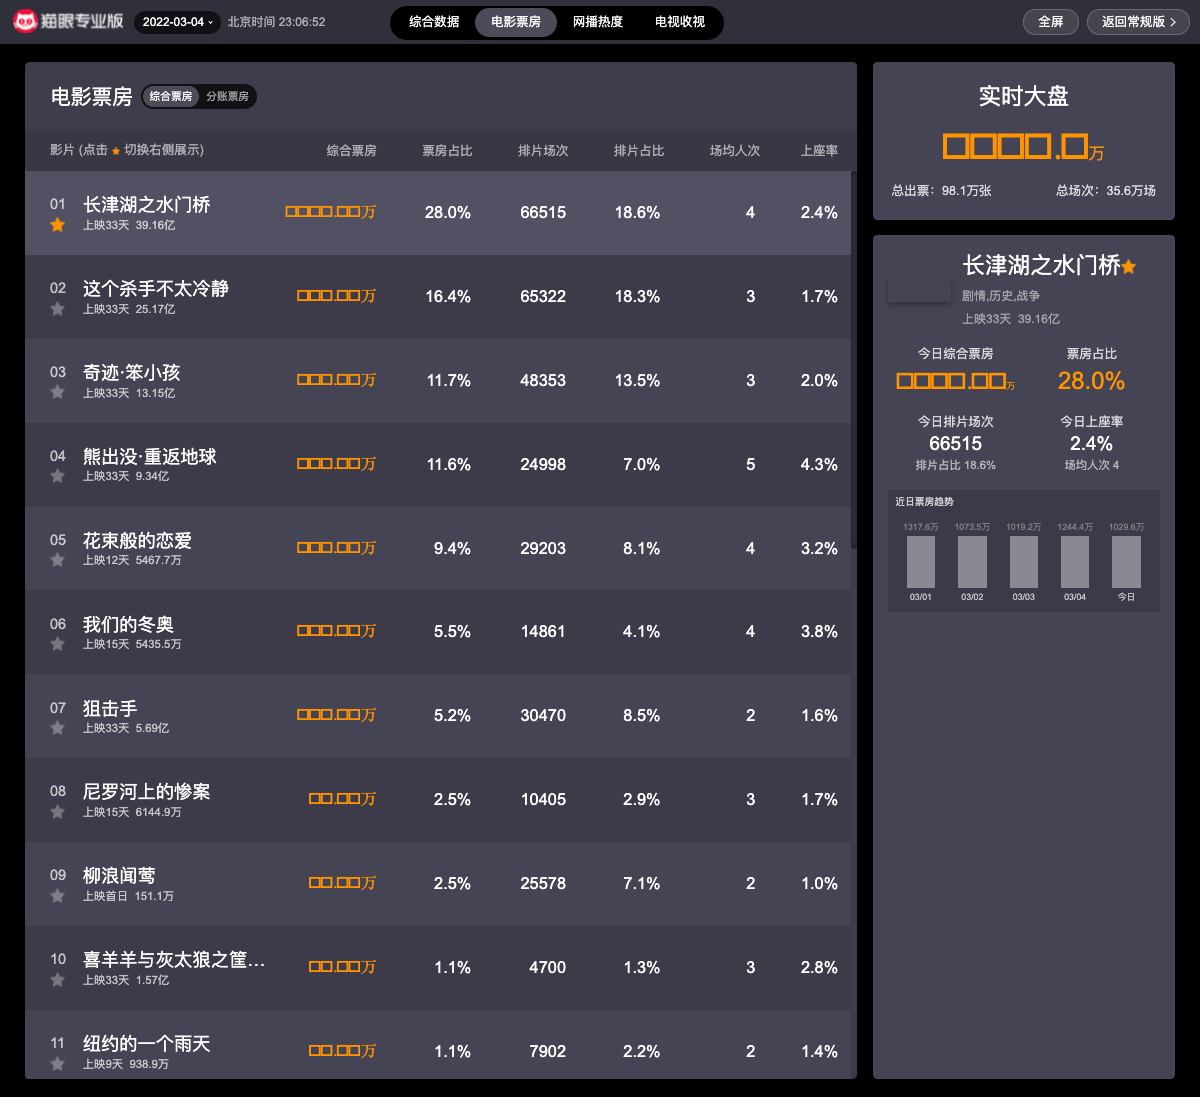

In [13]:
# Comparing with the screenshot earlier
from IPython.display import Image as displayImage
displayImage(filename="logs/" + now + "/screenshot.png") 

# Stage 2: Douban

In [14]:
browserOptions = Options()
#browserOptions.add_argument("--headless")

capa = DesiredCapabilities.CHROME
capa["pageLoadStrategy"] = "none"
capa["goog:loggingPrefs"] = {"performance": "ALL"}
driver = webdriver.Chrome(desired_capabilities=capa, chrome_options=browserOptions)
wait = WebDriverWait(driver, 20)

driver.get("https://movie.douban.com/")

test = None
while not test:
    try:
        test = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'nav')))
    except:
        pass
        #driver.refresh();

infoLst = []    
        
def getInfo(name):
    inputElement = driver.find_element_by_id('inp-query')
    inputElement.send_keys(name)
    inputElement.send_keys(Keys.ENTER)
    wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'cover-link')))
    firstMovie = driver.find_elements_by_class_name('cover-link')[0]
    firstMovie.click()
    res = requests.get(driver.current_url, headers=headers)
    soup = bs(res.text, 'lxml')
    sj = json.loads(soup.select_one('script[type^="application/ld+json"]').text, strict=False)
    infoLst.append(sj)

for i in df['movieInfo']:
    getInfo(i)
    
df_douban = pd.DataFrame.from_records(infoLst)
df_douban.to_csv("logs/" + now + "/douban_data.csv", encoding='utf_8_sig')

/Users/azicon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: use options instead of chrome_options
  import sys
/Users/azicon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead


TimeoutException: Message: 
Stacktrace:
0   chromedriver                        0x0000000105fe9e69 chromedriver + 5160553
1   chromedriver                        0x0000000105f74593 chromedriver + 4679059
2   chromedriver                        0x0000000105b282c8 chromedriver + 172744
3   chromedriver                        0x0000000105b5db62 chromedriver + 392034
4   chromedriver                        0x0000000105b5dd21 chromedriver + 392481
5   chromedriver                        0x0000000105b90304 chromedriver + 598788
6   chromedriver                        0x0000000105b7b3fd chromedriver + 513021
7   chromedriver                        0x0000000105b8e0ab chromedriver + 589995
8   chromedriver                        0x0000000105b7b623 chromedriver + 513571
9   chromedriver                        0x0000000105b50dce chromedriver + 339406
10  chromedriver                        0x0000000105b52105 chromedriver + 344325
11  chromedriver                        0x0000000105fa523e chromedriver + 4878910
12  chromedriver                        0x0000000105fbcd17 chromedriver + 4975895
13  chromedriver                        0x0000000105fc2a3f chromedriver + 4999743
14  chromedriver                        0x0000000105fbd61a chromedriver + 4978202
15  chromedriver                        0x0000000105f99bb1 chromedriver + 4832177
16  chromedriver                        0x0000000105fd9fd8 chromedriver + 5095384
17  chromedriver                        0x0000000105fda161 chromedriver + 5095777
18  chromedriver                        0x0000000105ff12a8 chromedriver + 5190312
19  libsystem_pthread.dylib             0x00007ff811e374f4 _pthread_start + 125
20  libsystem_pthread.dylib             0x00007ff811e3300f thread_start + 15


In [ ]:
df_douban